<a href="https://colab.research.google.com/github/Sylvia232/COMPSCI-675D-Final-Project/blob/main/CS_675_TARNET%2BSynthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Synthetic Data generation

In [2]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, image_shape):
        super().__init__()
        self.image_shape = image_shape
        C, H, W = image_shape
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, C * H * W),
            nn.Tanh()  # map to range[-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        return x.view(-1, *self.image_shape)

In [3]:
class Out_func(nn.Module): #define f_t(x, u)
    def __init__(self, d_X, d_U):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_X + d_U, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, u):
        x_flatten = x.view(x.size(0), -1) if x.dim() > 2 else x
        input = torch.cat([x_flatten, u], dim=1)
        return self.net(input).squeeze(-1)

In [24]:
def synthetic_generation(num_obs=5000, image_shape=(1, 32, 32), dz1=10, dz2=10, sig_x= 0.5, sig_u= 0.5, beta_mag=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    C, H, W = image_shape
    d_X = C * H * W
    d_U = dz2

    # Define G_X, G_U the mapping functions from latent dim to image

    # eval mode and no_grad modes are used to prevent gradient issues
    G_X = Decoder(dz1, image_shape).to(device)
    G_X.eval()

    class G_U(nn.Module):
        def __init__(self, dz2, d_U):
            super().__init__()
            self.linear = nn.Linear(dz2, d_U)

        def forward(self, z):
            return F.relu(self.linear(z))

    G_U = G_U(dz2, d_U).to(device)
    G_U.eval()

    # Define outcome functions for each treatment
    f_0 = Out_func(d_X, d_U).to(device)
    f_1 = Out_func(d_X, d_U).to(device)
    f_0.eval()
    f_1.eval()

    # Generate data without tracking gradients
    with torch.no_grad():

        # Define latent variables
        Z_1 = torch.randn(num_obs, dz1).to(device)
        Z_2 = torch.randn(num_obs, dz2).to(device)

        # Find X, U
        X = G_X(Z_1)
        X = X + sig_x * torch.randn_like(X)
        U = G_U(Z_2)
        U = U + sig_u * torch.randn_like(U)

        # Treatment t
        alpha = 0.01 * torch.randn(d_X).to(device)
        beta = beta_mag * torch.randn(d_U).to(device)

        probs = torch.sigmoid(X.view(num_obs, -1) @ alpha + U @ beta)
        treatments = torch.bernoulli(probs).to(device)

        # Outcomes Y
        x_flat = X.view(num_obs, -1)
        Y_0 = f_0(x_flat, U) + 0.01 * torch.randn(num_obs).to(device)
        Y_1 = f_1(x_flat, U) + 0.01 * torch.randn(num_obs).to(device)
        Y = torch.where(treatments == 1, Y_1, Y_0)

    # Detach from the computation graph to prevent gradient issues
    return X.detach(), treatments.detach(), Y.detach(), Y_0.detach(), Y_1.detach(), U.detach()


TARNET Architecture

In [25]:
# CNN Feature extractor for phi(x)
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels, output_dim=256):
        # input shape: (B, C, H, W)
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # gives dim (B, C, 1, 1)
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        rep = self.features(x)
        rep = rep.view(rep.size(0), -1)
        return self.fc(rep)


In [26]:
class TARNet(nn.Module):
    def __init__(self, cnn_feat, rep_dim=256, hidden_dim=200):
        super().__init__()

        # Shared representation layers for phi(x)
        self.cnn_feat = cnn_feat

        # Head for predicting Y_0 the outcome under treatment t_0
        self.head_0 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # Head for predicting Y_1 the outcome under treatment t_1
        self.head_1 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t=None):
        rep = self.cnn_feat(x)
        y0 = self.head_0(rep).squeeze(-1)
        y1 = self.head_1(rep).squeeze(-1)

        if t is None:
            return y0, y1, rep
        else:
            return torch.where(t == 1, y1, y0)


Training the TARNet with synthetic data

In [27]:
def train_tarnet(num_epochs=10, batch_size=64, lr=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    # Generate synthetic data
    print("Generating synthetic data...")
    X, treatments, Y, Y_0, Y_1, U = synthetic_generation(num_obs=5000)

    # Create model
    print("Creating model...")
    cnn_feat = CNNFeatureExtractor(in_channels=1, output_dim=256)
    model = TARNet(cnn_feat, rep_dim=256, hidden_dim=200)
    model = model.to(device)
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    # Dataset
    dataset = torch.utils.data.TensorDataset(X, treatments, Y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    print("Started training")
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (batch_X, batch_t, batch_Y) in enumerate(dataloader):
            optimizer.zero_grad()
            batch_X = batch_X.to(device)
            batch_t = batch_t.to(device)
            batch_Y = batch_Y.to(device)
            # Forward pass
            predictions = model(batch_X, batch_t)
            loss = criterion(predictions, batch_Y)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()


        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return model

In [28]:
def evaluate_model(model, test_size=1000):
    print("Evaluating model")
    # Generate test data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    X_test, t_test, Y_test, Y_0_test, Y_1_test, U_test = synthetic_generation(num_obs=test_size)

    X_test = X_test.to(device)
    t_test = t_test.to(device)
    Y_test = Y_test.to(device)
    Y_0_test = Y_0_test.to(device)
    Y_1_test = Y_1_test.to(device)

    model.eval()
    with torch.no_grad():
        # Get predictions for both potential outcomes
        y_0_pred, y_1_pred, _ = model(X_test, t=None)

        # Calculate MSE
        pred = model(X_test, t_test)
        mse = F.mse_loss(pred, Y_test).item()

        # Calculate PEHE (Precision in Estimation of Heterogeneous Effects)
        ite_true = Y_1_test - Y_0_test
        ite_pred = y_1_pred - y_0_pred
        pehe = torch.sqrt(F.mse_loss(ite_pred, ite_true)).item()

        print(f"MSE: {mse:.4f}")
        print(f"PEHE: {pehe:.4f}")


    return mse, pehe


In [29]:
# Train the model
trained_model = train_tarnet(num_epochs= 50, batch_size=64, lr=0.01)

Training on device: cuda
Generating synthetic data...
Using device: cuda
Creating model...
Started training
Epoch [1/50], Loss: 0.2625
Epoch [2/50], Loss: 0.0016
Epoch [3/50], Loss: 0.0015
Epoch [4/50], Loss: 0.0016
Epoch [5/50], Loss: 0.0016
Epoch [6/50], Loss: 0.0015
Epoch [7/50], Loss: 0.0016
Epoch [8/50], Loss: 0.0016
Epoch [9/50], Loss: 0.0015
Epoch [10/50], Loss: 0.0015
Epoch [11/50], Loss: 0.0015
Epoch [12/50], Loss: 0.0017
Epoch [13/50], Loss: 0.0018
Epoch [14/50], Loss: 0.0016
Epoch [15/50], Loss: 0.0016
Epoch [16/50], Loss: 0.0015
Epoch [17/50], Loss: 0.0015
Epoch [18/50], Loss: 0.0015
Epoch [19/50], Loss: 0.0015
Epoch [20/50], Loss: 0.0015
Epoch [21/50], Loss: 0.0015
Epoch [22/50], Loss: 0.0015
Epoch [23/50], Loss: 0.0015
Epoch [24/50], Loss: 0.0020
Epoch [25/50], Loss: 0.0017
Epoch [26/50], Loss: 0.0015
Epoch [27/50], Loss: 0.0015
Epoch [28/50], Loss: 0.0015
Epoch [29/50], Loss: 0.0015
Epoch [30/50], Loss: 0.0015
Epoch [31/50], Loss: 0.0015
Epoch [32/50], Loss: 0.0015
Epoch

In [30]:
#evaluate the model
mse_model, pehe = evaluate_model(trained_model)

Evaluating model
Training on device: cuda
Using device: cuda
MSE: 0.0213
PEHE: 0.2592


# Deliveries 1-3 for Synthetic

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
np.random.seed(0)

In [32]:
# ========= Extra loss: MMD between treated & control reps ========= #

def _gaussian_kernel(x, y, sigma=1.0):
    """
    x: (n, d), y: (m, d)
    returns: (n, m) kernel matrix
    """
    x = x.unsqueeze(1)  # (n, 1, d)
    y = y.unsqueeze(0)  # (1, m, d)
    diff = x - y
    dist_sq = (diff ** 2).sum(-1)
    k = torch.exp(-dist_sq / (2.0 * sigma ** 2))
    return k


def mmd_penalty(rep_treated, rep_control, sigma=1.0):
    """
    Maximum Mean Discrepancy (MMD) with RBF kernel.
    This encourages the representation of treated and control groups
    to have similar distributions (similar spirit as Wasserstein GAN).
    """
    if rep_treated.size(0) == 0 or rep_control.size(0) == 0:
        # If a mini-batch has only one group, skip the penalty.
        return torch.tensor(0.0, device=rep_treated.device)

    K_tt = _gaussian_kernel(rep_treated, rep_treated, sigma)
    K_cc = _gaussian_kernel(rep_control, rep_control, sigma)
    K_tc = _gaussian_kernel(rep_treated, rep_control, sigma)

    mmd = K_tt.mean() + K_cc.mean() - 2.0 * K_tc.mean()
    return mmd


In [33]:
# ========= Generic trainer & evaluator for TARNet on synthetic data ========= #


def train_tarnet_experiment(
    num_obs_train=5000,
    dz1=10,
    dz2=10,
    beta_mag=2.0,
    sig_x=0.5,
    sig_u=0.5,
    num_epochs=30,
    batch_size=64,
    lr=1e-3,
    balancing_alpha=0.0,
    mmd_sigma=1.0,
    verbose=True,
):
    """
    Train a TARNet model on the synthetic dataset with given confounder
    dimension and confounding strength. Optionally adds an MMD penalty
    between treated and control representations (balancing_alpha > 0).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose:
        print(f"Device: {device}")
        print(f"Training TARNet (dz2={dz2}, beta_mag={beta_mag}, alpha={balancing_alpha})")

    # Generate synthetic training data
    X, t, Y, Y_0, Y_1, U = synthetic_generation(
        num_obs=num_obs_train,
        dz1=dz1,
        dz2=dz2,
        sig_x=sig_x,
        sig_u=sig_u,
        beta_mag=beta_mag,
    )

    X = X.to(device)
    t = t.to(device)
    Y = Y.to(device)

    # Build TARNet model
    cnn_feat = CNNFeatureExtractor(in_channels=X.size(1), output_dim=256)
    model = TARNet(cnn_feat, rep_dim=256, hidden_dim=200).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    dataset = TensorDataset(X, t, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_t, batch_Y in dataloader:
            batch_X = batch_X.to(device)
            batch_t = batch_t.to(device)
            batch_Y = batch_Y.to(device)

            optimizer.zero_grad()

            # Forward through TARNet to get both potential outcomes and reps
            y0_hat, y1_hat, rep = model(batch_X, t=None)
            y_hat = torch.where(batch_t == 1, y1_hat, y0_hat)

            factual_loss = criterion(y_hat, batch_Y)

            # MMD balancing loss between treated & control representations
            if balancing_alpha > 0.0:
                rep_treated = rep[batch_t == 1]
                rep_control = rep[batch_t == 0]
                mmd_loss = mmd_penalty(rep_treated, rep_control, sigma=mmd_sigma)
            else:
                mmd_loss = torch.tensor(0.0, device=device)

            loss = factual_loss + balancing_alpha * mmd_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if verbose:
            print(f"[TARNet] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(dataloader):.4f}")

    return model

In [34]:
def evaluate_tarnet_metrics(
    model,
    num_obs_test=2000,
    dz1=10,
    dz2=10,
    beta_mag=2.0,
    sig_x=0.5,
    sig_u=0.5,
):
    """
    Evaluate TARNet on a fresh synthetic test set and compute:
    - MSE on factual outcomes
    - PEHE
    - ATE bias (estimated ATE - true ATE)
    """
    device = next(model.parameters()).device

    X_test, t_test, Y_test, Y_0_test, Y_1_test, U_test = synthetic_generation(
        num_obs=num_obs_test,
        dz1=dz1,
        dz2=dz2,
        sig_x=sig_x,
        sig_u=sig_u,
        beta_mag=beta_mag,
    )

    X_test = X_test.to(device)
    t_test = t_test.to(device)
    Y_test = Y_test.to(device)
    Y_0_test = Y_0_test.to(device)
    Y_1_test = Y_1_test.to(device)

    model.eval()
    with torch.no_grad():
        y0_pred, y1_pred, _ = model(X_test, t=None)
        y_pred = torch.where(t_test == 1, y1_pred, y0_pred)

        mse = F.mse_loss(y_pred, Y_test).item()

        ite_true = Y_1_test - Y_0_test
        ite_pred = y1_pred - y0_pred
        pehe = torch.sqrt(F.mse_loss(ite_pred, ite_true)).item()

        true_ate = ite_true.mean().item()
        pred_ate = ite_pred.mean().item()
        ate_bias = pred_ate - true_ate  # can also look at abs(ate_bias)

    return {
        "mse": mse,
        "pehe": pehe,
        "ate_bias": ate_bias,
        "true_ate": true_ate,
        "pred_ate": pred_ate,
    }

In [35]:
# ========= 1) PEHE & bias vs hidden confounder dimension ℓ ========= #

def run_hidden_dim_experiment(
    hidden_dims=(2, 4, 6, 8, 10),
    dz1=10,
    beta_mag=2.0,
    balancing_alpha=0.0,
):
    """
    Vary the hidden confounder dimension (dz2 = ℓ) and plot
    PEHE and ATE bias as functions of ℓ, for the synthetic data.
    Always returns (hidden_dims, results).
    """
    results = []

    for dz2 in hidden_dims:
        print(f"\n=== Hidden confounder dim dz2 = {dz2} ===")
        try:
            model = train_tarnet_experiment(
                dz1=dz1,
                dz2=dz2,
                beta_mag=beta_mag,
                balancing_alpha=balancing_alpha,
            )
            metrics = evaluate_tarnet_metrics(
                model,
                dz1=dz1,
                dz2=dz2,
                beta_mag=beta_mag,
            )
            print(f"PEHE: {metrics['pehe']:.4f}, ATE bias: {metrics['ate_bias']:.4f}")
            results.append(metrics)
        except Exception as e:
            print(f"❌ Error at dz2={dz2}: {e}")
            results.append(None)
            continue
    
    # Filter out None’s for plotting
    valid_dims = [d for (d,r) in zip(hidden_dims, results) if r is not None]
    valid_results = [r for r in results if r is not None]

    if len(valid_results) == 0:
        print("⚠️ No successful runs — check earlier errors.")
        return hidden_dims, results

    pehe_vals = [r["pehe"] for r in valid_results]
    bias_vals = [abs(r["ate_bias"]) for r in valid_results]

    # Plot PEHE
    plt.figure(figsize=(6, 4))
    plt.plot(valid_dims, pehe_vals, marker="o")
    plt.xlabel("Hidden confounder dimension ℓ (dz2)")
    plt.ylabel("PEHE")
    plt.title("PEHE vs hidden confounder dimension (synthetic)")
    plt.grid(True)
    plt.show()

    # Plot |ATE bias|
    plt.figure(figsize=(6, 4))
    plt.plot(valid_dims, bias_vals, marker="o")
    plt.xlabel("Hidden confounder dimension ℓ (dz2)")
    plt.ylabel("|ATE bias|")
    plt.title("ATE bias vs hidden confounder dimension (synthetic)")
    plt.grid(True)
    plt.show()

    return hidden_dims, results


In [36]:
# ========= 2) PEHE & bias vs confounding strength ||β|| ========= #

def run_beta_strength_experiment(
    beta_mags=(0.0, 0.5, 1.0, 1.5, 2.0, 3.0),
    dz1=10,
    dz2=10,
    balancing_alpha=0.0,
):
    """
    Vary the confounding strength (via beta_mag, which scales ||β||)
    and plot PEHE and ATE bias as functions of ||β||.
    """
    results = []
    for beta_mag in beta_mags:
        print(f"\n=== Confounding strength beta_mag = {beta_mag} ===")
        model = train_tarnet_experiment(
            dz1=dz1,
            dz2=dz2,
            beta_mag=beta_mag,
            balancing_alpha=balancing_alpha,
        )
        metrics = evaluate_tarnet_metrics(
            model,
            dz1=dz1,
            dz2=dz2,
            beta_mag=beta_mag,
        )
        print(f"PEHE: {metrics['pehe']:.4f}, ATE bias: {metrics['ate_bias']:.4f}")
        results.append(metrics)

    pehe_vals = [r["pehe"] for r in results]
    bias_vals = [r["ate_bias"] for r in results]

    # Plot PEHE vs ||β||
    plt.figure(figsize=(6, 4))
    plt.plot(beta_mags, pehe_vals, marker="o")
    plt.xlabel("Confounding strength ∥β∥ (beta_mag)")
    plt.ylabel("PEHE")
    plt.title("PEHE vs confounding strength (synthetic)")
    plt.grid(True)
    plt.show()

    # Plot |bias| vs ||β||
    plt.figure(figsize=(6, 4))
    plt.plot(beta_mags, np.abs(bias_vals), marker="o")
    plt.xlabel("Confounding strength ∥β∥ (beta_mag)")
    plt.ylabel("|ATE bias|")
    plt.title("ATE bias vs confounding strength (synthetic)")
    plt.grid(True)
    plt.show()

    return beta_mags, results

In [37]:
# ========= 2b) Effect of representation balancing loss (MMD) ========= #

def run_balancing_experiment(
    alphas=(0.0, 1.0),
    dz1=10,
    dz2=10,
    beta_mag=2.0,
):
    """
    Train TARNet with different balancing_alpha values (strength of MMD penalty)
    and compare PEHE / ATE bias.
    """
    metrics_by_alpha = {}
    for alpha in alphas:
        print(f"\n=== Training TARNet with balancing_alpha = {alpha} ===")
        model = train_tarnet_experiment(
            dz1=dz1,
            dz2=dz2,
            beta_mag=beta_mag,
            balancing_alpha=alpha,
        )
        metrics = evaluate_tarnet_metrics(
            model,
            dz1=dz1,
            dz2=dz2,
            beta_mag=beta_mag,
        )
        metrics_by_alpha[alpha] = metrics
        print(f"alpha={alpha}: PEHE={metrics['pehe']:.4f}, ATE bias={metrics['ate_bias']:.4f}")

    # Simple bar plots for PEHE and |bias|
    alpha_list = list(alphas)
    pehe_vals = [metrics_by_alpha[a]["pehe"] for a in alpha_list]
    bias_vals = [abs(metrics_by_alpha[a]["ate_bias"]) for a in alpha_list]

    x = np.arange(len(alpha_list))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x, pehe_vals, width)
    plt.xticks(x, [str(a) for a in alpha_list])
    plt.xlabel("balancing_alpha")
    plt.ylabel("PEHE")
    plt.title("Effect of MMD balancing loss on PEHE")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.bar(x, bias_vals, width)
    plt.xticks(x, [str(a) for a in alpha_list])
    plt.xlabel("balancing_alpha")
    plt.ylabel("|ATE bias|")
    plt.title("Effect of MMD balancing loss on ATE bias")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

    return metrics_by_alpha


In [38]:
# ========= 3) Propensity-informed TARNet (Deliveries bullet 3) ========= #

class PropensityNet(nn.Module):
    """Simple CNN-based propensity estimator e_hat(x) = P(T=1 | X)."""
    def __init__(self, in_channels, rep_dim=128):
        super().__init__()
        self.cnn_feat = CNNFeatureExtractor(in_channels=in_channels, output_dim=rep_dim)
        self.classifier = nn.Sequential(
            nn.Linear(rep_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        rep = self.cnn_feat(x)
        logits = self.classifier(rep).squeeze(-1)
        return torch.sigmoid(logits)


class TARNetWithPropensity(nn.Module):
    """TARNet that concatenates estimated propensity e_hat(x) to Φ(x)."""
    def __init__(self, cnn_feat, rep_dim=256, hidden_dim=200):
        super().__init__()
        self.cnn_feat = cnn_feat
        self.head_0 = nn.Sequential(
            nn.Linear(rep_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.head_1 = nn.Sequential(
            nn.Linear(rep_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x, t=None, e_hat=None):
        if e_hat is None:
            raise ValueError("e_hat (estimated propensity) must be provided")

        rep = self.cnn_feat(x)
        if e_hat.dim() == 1:
            e_hat = e_hat.unsqueeze(1)
        rep_aug = torch.cat([rep, e_hat], dim=1)

        y0 = self.head_0(rep_aug).squeeze(-1)
        y1 = self.head_1(rep_aug).squeeze(-1)

        if t is None:
            return y0, y1, rep_aug
        else:
            return torch.where(t == 1, y1, y0)

In [39]:
def train_propensity_model(X, t, num_epochs=20, batch_size=64, lr=1e-3, verbose=True):
    """
    Train a propensity model e_hat(x) = P(T=1 | X) using CNN features.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X = X.to(device)
    t = t.to(device).float()

    model = PropensityNet(in_channels=X.size(1)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCELoss()

    dataset = TensorDataset(X, t)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_t in dataloader:
            batch_X = batch_X.to(device)
            batch_t = batch_t.to(device)

            optimizer.zero_grad()
            p_hat = model(batch_X)
            loss = criterion(p_hat, batch_t)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if verbose:
            print(f"[Propensity] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(dataloader):.4f}")

    return model


def run_propensity_informed_experiment(
    num_obs_train=5000,
    num_obs_test=2000,
    dz1=10,
    dz2=10,
    beta_mag=2.0,
):
    """
    Train baseline TARNet and propensity-informed TARNet and compare metrics.
    This corresponds to Deliveries bullet 3.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    print("\n=== Generating synthetic data for propensity experiment ===")
    X, t, Y, Y_0, Y_1, U = synthetic_generation(
        num_obs=num_obs_train,
        dz1=dz1,
        dz2=dz2,
        beta_mag=beta_mag,
    )
    X = X.to(device)
    t = t.to(device)
    Y = Y.to(device)

    # ----- Baseline TARNet -----
    print("\n=== Training baseline TARNet ===")
    baseline_model = train_tarnet_experiment(
        num_obs_train=num_obs_train,
        dz1=dz1,
        dz2=dz2,
        beta_mag=beta_mag,
        balancing_alpha=0.0,
        verbose=False,
    )
    baseline_metrics = evaluate_tarnet_metrics(
        baseline_model,
        num_obs_test=num_obs_test,
        dz1=dz1,
        dz2=dz2,
        beta_mag=beta_mag,
    )
    print(f"Baseline TARNet - PEHE: {baseline_metrics['pehe']:.4f}, ATE bias: {baseline_metrics['ate_bias']:.4f}")

    # ----- Propensity-informed TARNet -----
    print("\n=== Training propensity model ===")
    prop_model = train_propensity_model(X, t, verbose=False)

    with torch.no_grad():
        e_hat_train = prop_model(X).detach()

    cnn_feat = CNNFeatureExtractor(in_channels=X.size(1), output_dim=256)
    prop_tarnet = TARNetWithPropensity(cnn_feat, rep_dim=256, hidden_dim=200).to(device)
    optimizer = optim.Adam(prop_tarnet.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    dataset = TensorDataset(X, t, Y, e_hat_train)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    print("\n=== Training propensity-informed TARNet ===")
    prop_tarnet.train()
    num_epochs = 30
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_t, batch_Y, batch_e in dataloader:
            batch_X = batch_X.to(device)
            batch_t = batch_t.to(device)
            batch_Y = batch_Y.to(device)
            batch_e = batch_e.to(device)

            optimizer.zero_grad()
            y0_hat, y1_hat, _ = prop_tarnet(batch_X, t=None, e_hat=batch_e)
            y_hat = torch.where(batch_t == 1, y1_hat, y0_hat)
            loss = criterion(y_hat, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"[Prop-TARNet] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(dataloader):.4f}")

    # Evaluate on fresh test data (also using propensity model to get e_hat on test X)
    X_test, t_test, Y_test, Y_0_test, Y_1_test, U_test = synthetic_generation(
        num_obs=num_obs_test,
        dz1=dz1,
        dz2=dz2,
        beta_mag=beta_mag,
    )
    X_test = X_test.to(device)
    t_test = t_test.to(device)
    Y_test = Y_test.to(device)
    Y_0_test = Y_0_test.to(device)
    Y_1_test = Y_1_test.to(device)

    with torch.no_grad():
        e_hat_test = prop_model(X_test)
        y0_pred, y1_pred, _ = prop_tarnet(X_test, t=None, e_hat=e_hat_test)
        y_pred = torch.where(t_test == 1, y1_pred, y0_pred)

        mse = F.mse_loss(y_pred, Y_test).item()
        ite_true = Y_1_test - Y_0_test
        ite_pred = y1_pred - y0_pred
        pehe = torch.sqrt(F.mse_loss(ite_pred, ite_true)).item()
        true_ate = ite_true.mean().item()
        pred_ate = ite_pred.mean().item()
        ate_bias = pred_ate - true_ate

    prop_metrics = {
        "mse": mse,
        "pehe": pehe,
        "ate_bias": ate_bias,
        "true_ate": true_ate,
        "pred_ate": pred_ate,
    }

    print(f"Propensity-informed TARNet - PEHE: {pehe:.4f}, ATE bias: {ate_bias:.4f}")

    # Simple comparison bar plot for PEHE and |bias|
    labels = ["Baseline", "Propensity-informed"]
    pehe_vals = [baseline_metrics["pehe"], prop_metrics["pehe"]]
    bias_vals = [abs(baseline_metrics["ate_bias"]), abs(prop_metrics["ate_bias"])]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width / 2, pehe_vals, width, label="PEHE")
    plt.bar(x + width / 2, bias_vals, width, label="|ATE bias|")
    plt.xticks(x, labels)
    plt.ylabel("Error")
    plt.title("Baseline vs Propensity-informed TARNet (synthetic)")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

    return baseline_metrics, prop_metrics


=== Hidden confounder dim dz2 = 2 ===
Device: cuda
Training TARNet (dz2=2, beta_mag=2.0, alpha=0.0)
Using device: cuda
[TARNet] Epoch 1/30 - Loss: 0.0022
[TARNet] Epoch 2/30 - Loss: 0.0017
[TARNet] Epoch 3/30 - Loss: 0.0016
[TARNet] Epoch 4/30 - Loss: 0.0017
[TARNet] Epoch 5/30 - Loss: 0.0016
[TARNet] Epoch 6/30 - Loss: 0.0017
[TARNet] Epoch 7/30 - Loss: 0.0017
[TARNet] Epoch 8/30 - Loss: 0.0016
[TARNet] Epoch 9/30 - Loss: 0.0016
[TARNet] Epoch 10/30 - Loss: 0.0017
[TARNet] Epoch 11/30 - Loss: 0.0016
[TARNet] Epoch 12/30 - Loss: 0.0017
[TARNet] Epoch 13/30 - Loss: 0.0017
[TARNet] Epoch 14/30 - Loss: 0.0016
[TARNet] Epoch 15/30 - Loss: 0.0016
[TARNet] Epoch 16/30 - Loss: 0.0016
[TARNet] Epoch 17/30 - Loss: 0.0016
[TARNet] Epoch 18/30 - Loss: 0.0016
[TARNet] Epoch 19/30 - Loss: 0.0016
[TARNet] Epoch 20/30 - Loss: 0.0016
[TARNet] Epoch 21/30 - Loss: 0.0016
[TARNet] Epoch 22/30 - Loss: 0.0016
[TARNet] Epoch 23/30 - Loss: 0.0016
[TARNet] Epoch 24/30 - Loss: 0.0016
[TARNet] Epoch 25/30 - Lo

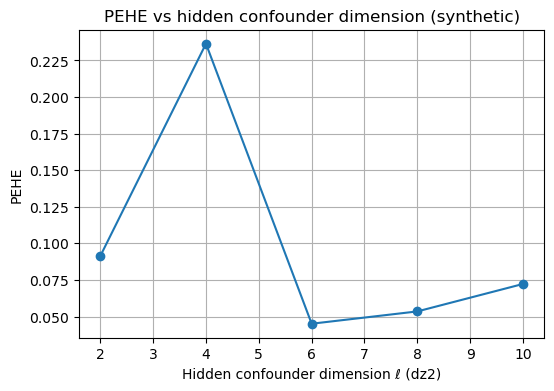

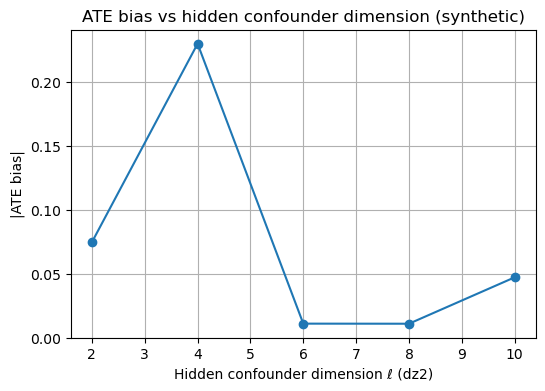

In [40]:
# PEHE & bias vs hidden confounder dimension ℓ
hidden_dims, hidden_results = run_hidden_dim_experiment()


=== Confounding strength beta_mag = 0.0 ===
Device: cuda
Training TARNet (dz2=10, beta_mag=0.0, alpha=0.0)
Using device: cuda
[TARNet] Epoch 1/30 - Loss: 0.0016
[TARNet] Epoch 2/30 - Loss: 0.0015
[TARNet] Epoch 3/30 - Loss: 0.0015
[TARNet] Epoch 4/30 - Loss: 0.0014
[TARNet] Epoch 5/30 - Loss: 0.0015
[TARNet] Epoch 6/30 - Loss: 0.0014
[TARNet] Epoch 7/30 - Loss: 0.0014
[TARNet] Epoch 8/30 - Loss: 0.0015
[TARNet] Epoch 9/30 - Loss: 0.0014
[TARNet] Epoch 10/30 - Loss: 0.0014
[TARNet] Epoch 11/30 - Loss: 0.0014
[TARNet] Epoch 12/30 - Loss: 0.0014
[TARNet] Epoch 13/30 - Loss: 0.0014
[TARNet] Epoch 14/30 - Loss: 0.0014
[TARNet] Epoch 15/30 - Loss: 0.0014
[TARNet] Epoch 16/30 - Loss: 0.0014
[TARNet] Epoch 17/30 - Loss: 0.0014
[TARNet] Epoch 18/30 - Loss: 0.0014
[TARNet] Epoch 19/30 - Loss: 0.0014
[TARNet] Epoch 20/30 - Loss: 0.0014
[TARNet] Epoch 21/30 - Loss: 0.0014
[TARNet] Epoch 22/30 - Loss: 0.0014
[TARNet] Epoch 23/30 - Loss: 0.0014
[TARNet] Epoch 24/30 - Loss: 0.0014
[TARNet] Epoch 25/

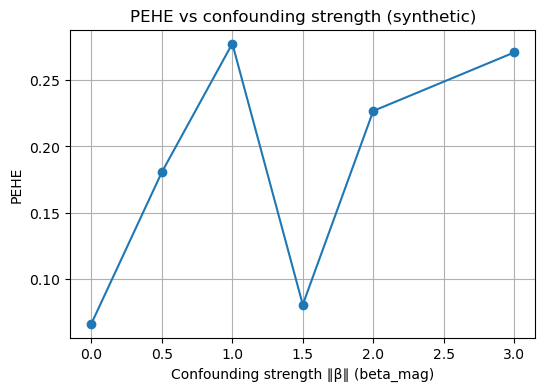

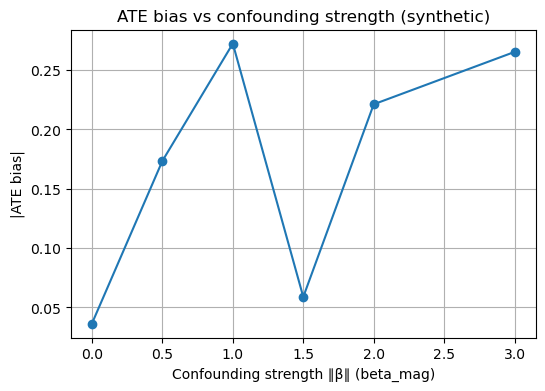

In [41]:
# PEHE & bias vs confounding strength ||β||
beta_mags, beta_results = run_beta_strength_experiment()

In [ ]:
# Compare no balancing vs MMD balancing (you can tweak alphas)
balancing_results = run_balancing_experiment(alphas=(0.0, 1.0))


=== Training TARNet with balancing_alpha = 0.0 ===
Device: cuda
Training TARNet (dz2=10, beta_mag=2.0, alpha=0.0)
Using device: cuda
[TARNet] Epoch 1/30 - Loss: 0.0016
[TARNet] Epoch 2/30 - Loss: 0.0010
[TARNet] Epoch 3/30 - Loss: 0.0010
[TARNet] Epoch 4/30 - Loss: 0.0010
[TARNet] Epoch 5/30 - Loss: 0.0010
[TARNet] Epoch 6/30 - Loss: 0.0010
[TARNet] Epoch 7/30 - Loss: 0.0010
[TARNet] Epoch 8/30 - Loss: 0.0010
[TARNet] Epoch 9/30 - Loss: 0.0010
[TARNet] Epoch 10/30 - Loss: 0.0010
[TARNet] Epoch 11/30 - Loss: 0.0010
[TARNet] Epoch 12/30 - Loss: 0.0010
[TARNet] Epoch 13/30 - Loss: 0.0010
[TARNet] Epoch 14/30 - Loss: 0.0010
[TARNet] Epoch 15/30 - Loss: 0.0010
[TARNet] Epoch 16/30 - Loss: 0.0010
[TARNet] Epoch 17/30 - Loss: 0.0010
[TARNet] Epoch 18/30 - Loss: 0.0010
[TARNet] Epoch 19/30 - Loss: 0.0010
[TARNet] Epoch 20/30 - Loss: 0.0010
[TARNet] Epoch 21/30 - Loss: 0.0010
[TARNet] Epoch 22/30 - Loss: 0.0010
[TARNet] Epoch 23/30 - Loss: 0.0010
[TARNet] Epoch 24/30 - Loss: 0.0010
[TARNet] Ep

In [ ]:
baseline_metrics, prop_metrics = run_propensity_informed_experiment()